<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tokenitzadors ràpids en el pipeline de question-answering**

---

Aprofitar les compensacions per agafar la resposta a la pregunta en qüestió des del context, una mica com vam fer amb les entitats agrupades a la secció anterior. Després veurem com podem fer front a contextos molt llargs que s'acaben truncant.

Objectiu: trobar la resposta a una qüestió plantejada en un context determinat.

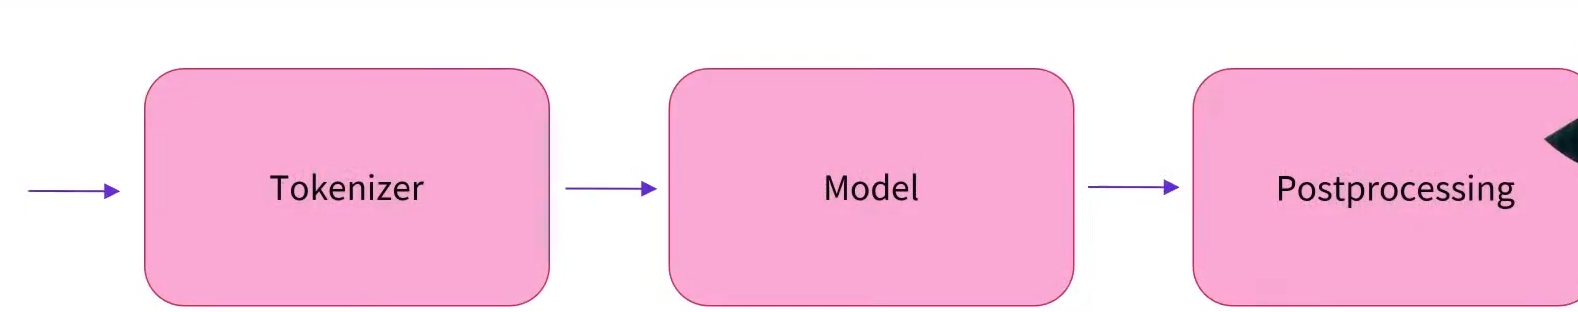

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

Els tokens alimenten al model:

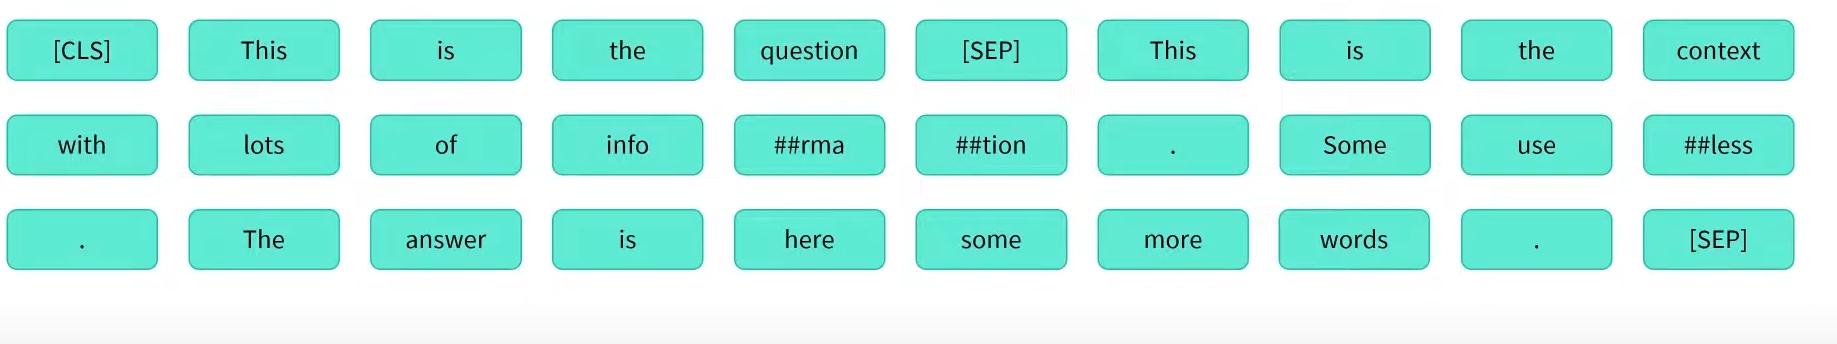


S'assignen etiquetes del tipus:

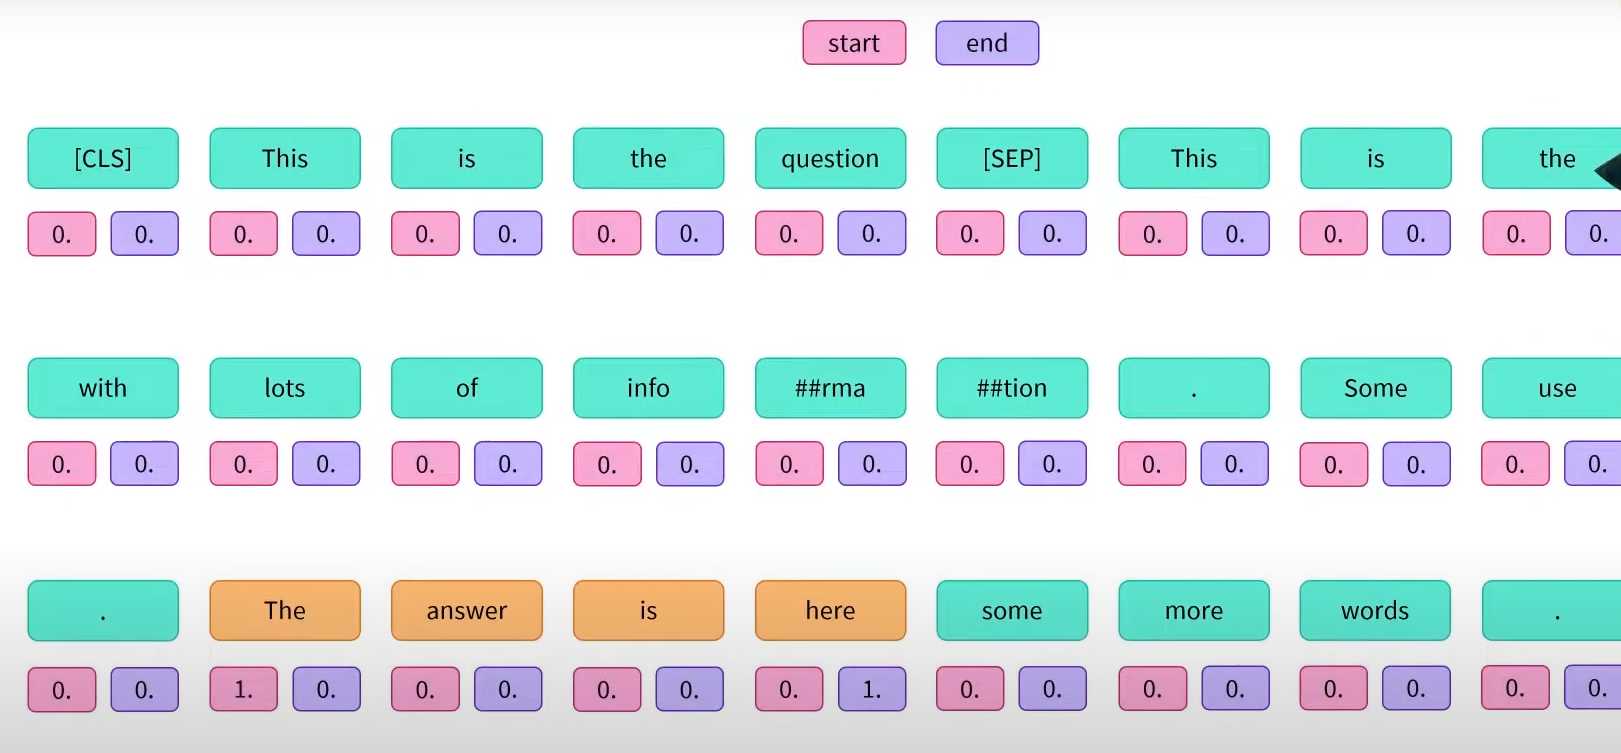

**start i end:**

* Són índexs de caràcter dins del context original.

* Indiquen on comença i on acaba la resposta seleccionada per part del model.

In [ ]:
long_context = """
Transformers: State of the Art NLP

Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

La resposta és un par d'inici i final posició:
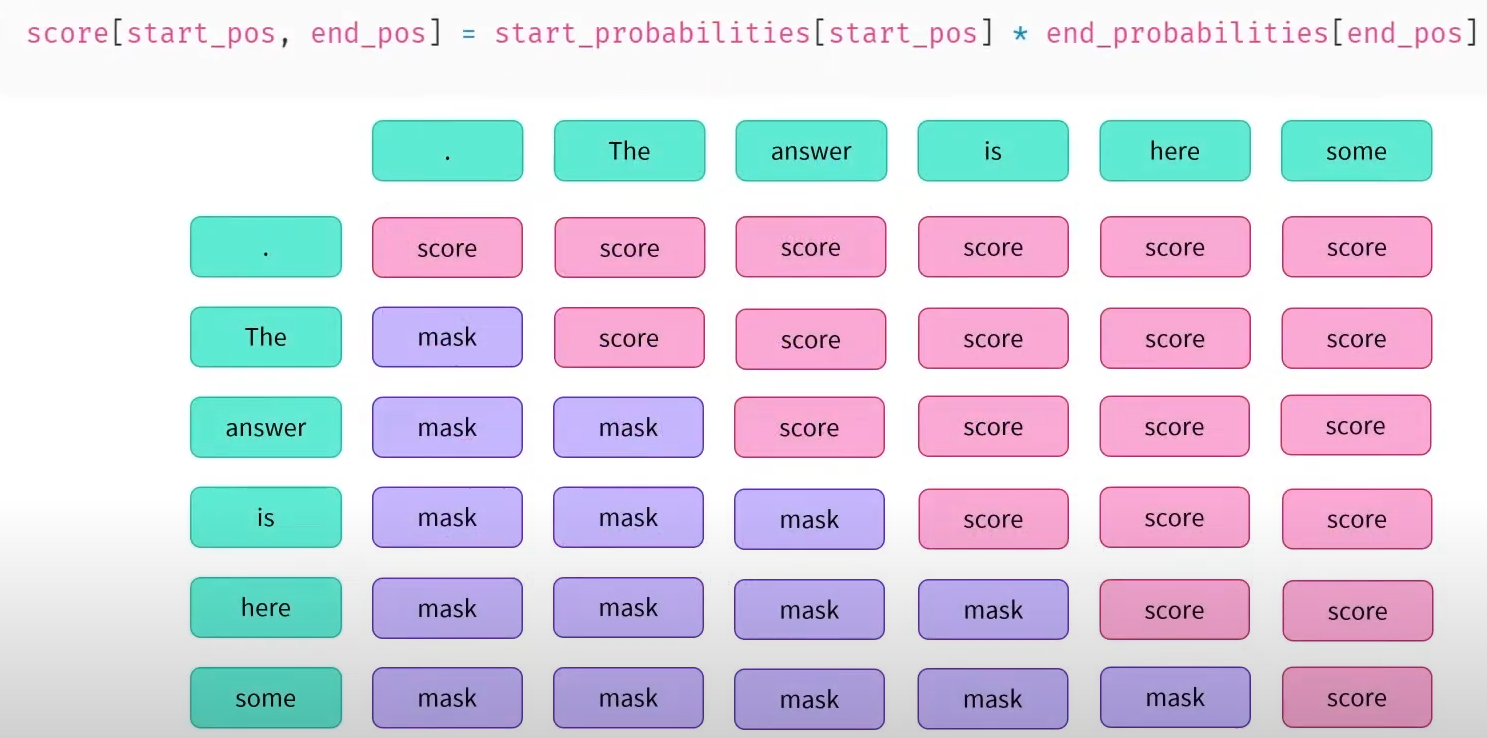

# **Ús d'un model per respondre preguntes**

---
Com amb qualsevol altre pipeline, comencem per tokenitzar la nostra entrada i després l'enviem a través del model. El punt de control utilitzat per defecte per al question-answeringpipeline és distilbert-base-cased-distilled-squad(el "esquadró" del nom prové del conjunt de dades en què es va ajustar el mode.

Quan s'utilitza un model de question-answering com BERT fine-tuned per SQuAD, la sortida conté dues prediccions principals:

1. **start_logits**: Probabilitat (en forma de logit) que cada token sigui l'inici
de la resposta.

1. **end_logits**: Probabilitat que cada token sigui el final de la resposta.

Forma (1, 67) explicada
Dimensions:
  * 1 → indica que es treballa amb un únic exemple (batch size = 1).

  * 67 → vol dir que el model ha processat 67 tokens després de tokenitzar el context + pregunta junts.

**Això inclou**:

* Tokens de la pregunta

* El separador [SEP]

* Tokens del context

* El token especial [CLS], si n'hi ha


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="tf")
outputs = model(**inputs)

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

Per convertir aquests logits en probabilitats, aplicarem una funció softmax, però abans d'això, ens hem d'assegurar d'emmascarar els índexs que no formen part del context. La nostra entrada és [CLS] question [SEP] context [SEP], de manera que hem d'emmascarar les fitxes de la pregunta així com el [SEP]testimoni. Mantendrem el [CLS]testimoni, però, ja que alguns models l'utilitzen per indicar que la resposta no està en el context.

Permet filtrar els logits perquè el model només consideri tokens del context com a possibles respostes, ignorant els de la pregunta i els tokens especials com [CLS] i [SEP].

Sense aquest pas, el model podria predir com a resposta un token de la pregunta o un token especial, cosa que no tindria sentit. Amb aquest filtratge:

Només els tokens del context són vàlids com a inici i final de la resposta.

És un pas essencial quan no utilitzes el pipeline de Transformers, sinó que treballes amb el model "a mà".

In [5]:
import tensorflow as tf

sequence_ids = inputs.sequence_ids()

# Aquesta funció retorna una llista d'identificadors que indiquen a quin segment pertany cada token.

# Habitualment:

# None → tokens especials com [CLS] o [SEP]

# 0 → tokens de la pregunta

# 1 → tokens del context
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Aquesta línia crea una màscara booleana que és True per a tot el que no és context.
# En altres paraules, marca els tokens que NO volem tenir en compte per trobar la resposta.
mask[0] = False
# Aquí es desactiva la màscara per al token [CLS] (que sol estar a la posició 0),
# per si es vol considerar com a opció de resposta (encara que no sigui comú).
mask = tf.constant(mask)[None]
# Es converteix la llista Python en un tensor de TensorFlow i
# s’afegeix una dimensió extra per representar el batch ([None] equival a [1, len(mask)]).

start_logits = tf.where(mask, -10000, start_logits)
end_logits = tf.where(mask, -10000, end_logits)

# Substitueix els logits de les posicions no context per un valor molt petit: -10000.
# Això fa que la funció argmax mai seleccioni aquestes posicions com a candidats de resposta, perquè les seves puntuacions són extremadament baixes.

In [6]:
start_probabilities = tf.math.softmax(start_logits, axis=-1)[0].numpy()
end_probabilities = tf.math.softmax(end_logits, axis=-1)[0].numpy()

# Ara que hem emmascarat correctament els logits corresponents a posicions que no volem predir, podem aplicar el softmax:

**Procés:**

1. Filtrar només combinacions vàlides (i ≤ j)

1. Trobar la millor combinació de tokens per la resposta

1. Saber quina és la puntuació màxima assignada pel model a aquesta combinació

In [7]:
scores = start_probabilities[:, None] * end_probabilities[None, :]
# Serveix per calcular una matriu de puntuacions per a totes les combinacions possibles d’inici i final de resposta.

In [8]:
import numpy as np

scores = np.triu(scores)

In [ ]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

Tenim el **start_index** i **end_index** de la resposta en termes de fitxes, així que ara només ens cal convertir als índexs de caràcters del context. Aquí és on els desplaçaments seran molt útils. Els podem agafar i utilitzar-los com vam fer a la tasca de classificació de fitxes:

In [10]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

In [ ]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)